# S&P 500 Price Data Exploration 2010-2023

The first step in increasing the data for our model will be expanding the number of years we examine. Instead of just 2018, we are going to look at the last 14 completed years. This document does not incorporate any of our NLP work but instead just examines how the S&P500 index has behaved over these years.

### Data and Imports
Will be using pretty standard packages for this data exploration, will be using pandas for manipulation and matplotlib and plotly for visualization. The data used is daily historical price data from yahoo finance.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import csv
from datetime import datetime

%matplotlib inline

In [8]:
stock_data = pd.read_csv('spy_daily_historical.csv')

Also going to add a column to this df to get the price change (close - open) and price change percent for each given day and switch the date to a datetime object.

In [9]:
stock_data['Price Change'] = stock_data['Close'] - stock_data['Open']
stock_data['Price Change %'] = (stock_data['Price Change'] / stock_data['Open']) * 100
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

### S&P 500 Price Movement
First I will plot just general price movement over the time window so we can just get a general understanding of the movement trends of this index fund.

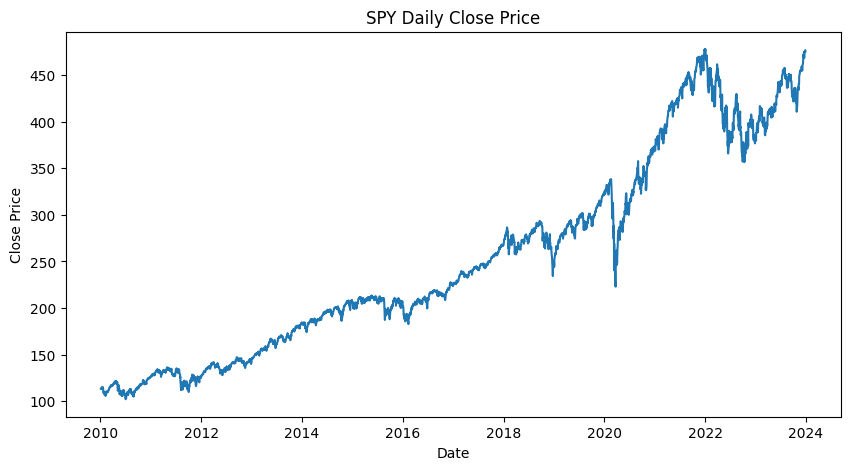

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(stock_data['Date'], stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SPY Daily Close Price')
plt.show()

Daily Price Change Distribution:

<Axes: >

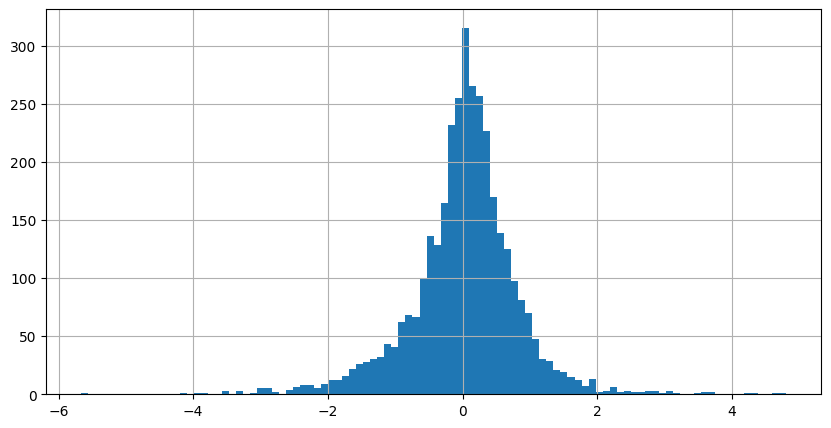

In [13]:
stock_data['Price Change %'].hist(bins=100, figsize=(10, 5))

In [14]:
stock_data['Price Change %'].describe()

count    3522.000000
mean        0.022538
std         0.808701
min        -5.661154
25%        -0.330550
50%         0.059920
75%         0.429011
max         4.799407
Name: Price Change %, dtype: float64

Create quarterly df to plot based on quarter:

In [11]:
stock_data['Quarter'] = stock_data['Date'].dt.year.astype(str) + ' Q' + stock_data['Date'].dt.quarter.astype(str)

quarterly_data = stock_data.groupby('Quarter').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum', 'Price Change': 'sum', 'Price Change %': 'sum'}).reset_index()
quarterly_data.tail(2)

,Quarter,Open,High,Low,Close,Volume,Price Change,Price Change %
54,2023 Q3,442.920013,459.440002,422.290009,427.480011,4718070300,-22.23999,-4.923921
55,2023 Q4,426.619995,477.549988,409.209991,475.309998,5142218400,27.76004,6.201758


In [12]:
fig = go.Figure(data=[go.Candlestick(x=quarterly_data['Quarter'],
                open=quarterly_data['Open'],
                high=quarterly_data['High'],
                low=quarterly_data['Low'],
                close=quarterly_data['Close'])])

fig.update_layout(
    title='SPY Quarterly Candlestick Chart',
    xaxis_title='Quarter',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False
    )

fig.show()

Quarterly Price Change Distribution:

<Axes: >

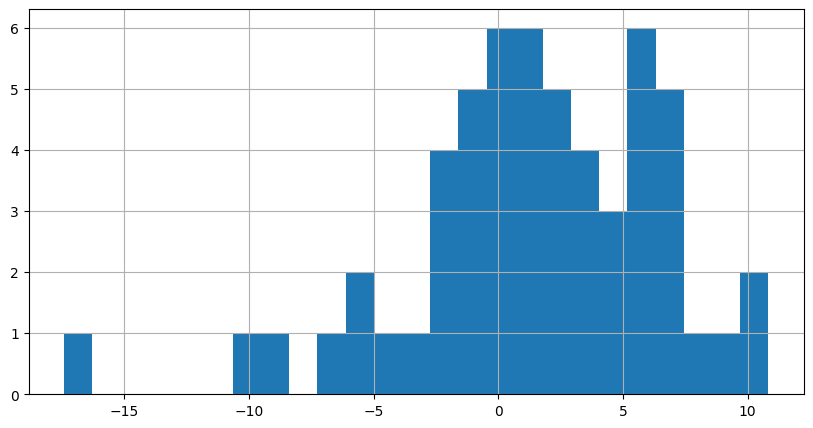

In [17]:
quarterly_data['Price Change %'].hist(bins=25, figsize=(10, 5))

In [ ]:
quarterly_data['Price Change %'].describe()

### Price Change Classification Exploration
Because our project mostly revolves around price change classification (predicting whether a stock will go up or down)